In [33]:
import sys

# setting path
sys.path.append('../')
import TestFunctions as tf
import EvaluationTracker as et
import CV5.DifferentialEvolution as diff
import CV6.PartialSwarm as swarm
import CV7.SOMA as soma
import CV9.Fireflies as fire
#import TestFunctions as tf
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from importlib import reload
import random
import time
import matplotlib.animation as animation
import math
import copy
import pandas as pd
import os



if not os.path.exists("tables"):
    os.mkdir("tables")
if not os.path.exists("csv"):
    os.mkdir("csv")

In [32]:
import importlib
importlib.reload(diff)
importlib.reload(swarm)
importlib.reload(soma)
importlib.reload(fire)

<module 'CV9.Fireflies' from 'c:\\Users\\BoushiPC\\Documents\\PythonScripts\\BIA\\CV10\\..\\CV9\\Fireflies.py'>

In [6]:
class Solution:
    def __init__(self, dimension, lower_bound, upper_bound):
        self.d = dimension
        self.lower = lower_bound # we will use the same bounds for all parameters
        self.upper = upper_bound
        self.params = np.zeros(self.d) #solution parameters
        self.f = np.inf # objective function evaluation

In [30]:
def generatePopulation(solution : Solution, size):
    population = []
    for _ in range(0, size):
        new_solution = Solution(len(solution.params), solution.lower, solution.upper) # Generate solution
        for i in range(0, len(solution.params)): 
            new_solution.params[i] = random.uniform(solution.lower, solution.upper) # Generate its params
            #print(new_solution.params)
        population.append(new_solution)
    return population

def evaluateAll(population : list[Solution], func, evaluationTracker : et.EvaluationTracker):
    for member in population:
        member.f = func(member.params)
        evaluationTracker.currentEvalCount += 1 # Record evaluation

def pickBest(population : Solution):
    bestScore = sys.maxsize
    bestSolution = None
    for solution in population:
        if solution.f < bestScore:
            bestScore = solution.f
            bestSolution = solution
    return copy.copy(bestSolution)

def calculateMean(population):
    totalSum = np.zeros(len(population[0].params)) # Init array with shape (n, 1), where n is number of dimensions
    for member in population:
        totalSum += np.array(member.params)
    return totalSum/len(population)


def TLBOAlgorithm(solution : Solution, func):
    evaluationTracker = et.EvaluationTracker() # This is custom class that will keep track of evaluations of cost functions for task 10 
    n_population = 30
    population = generatePopulation(solution, n_population)
    evaluateAll(population, func, evaluationTracker)
    max_iter = 100
    progressTracker = []
    for _ in range(max_iter):
        # Teacher phase
        bestSolution = pickBest(population) # Find the teacher
        if len(progressTracker) == 0: # If this is first best solution
            progressTracker.append((bestSolution.params.copy()[0], bestSolution.params.copy()[1], bestSolution.f))
        populationMean = calculateMean(population=population) # Calculate mean of population
        r = random.uniform(0,1) # Random val r
        T_f = np.random.randint(1,3) # Random val T_f
        difference = r * (np.array(bestSolution.params) - T_f * populationMean) # Get the difference of each parameter(dimension) from mean for teacher
        potentialTeacher = np.array(bestSolution.params) + difference
        newEval = func(potentialTeacher)
        evaluationTracker.currentEvalCount += 1
        if evaluationTracker.currentEvalCount > evaluationTracker.maxEval: # If max eval count has been reached, finish algorithm
            return progressTracker
        if newEval <= bestSolution.f: # Check if new potential teacher is better than current teacher
            bestSolution.params = list(potentialTeacher)
            bestSolution.f = newEval
            progressTracker.append((bestSolution.params.copy()[0], bestSolution.params.copy()[1], bestSolution.f))
        new_population = population.copy()
        # Teach students
        for i in range(len(population)):
            r = random.uniform(0,1) # Random val r
            difference = r * (np.array(bestSolution.params) - T_f * populationMean) # Move learner towards teacher 
            new_population[i].params = np.array(new_population[i].params) + difference
            new_population[i].params = np.clip(new_population[i].params, solution.lower, solution.upper) # Make sure student is in bounds 
            new_population[i].f = func(new_population[i].params)
            evaluationTracker.currentEvalCount += 1
            if evaluationTracker.currentEvalCount > evaluationTracker.maxEval: # If max eval count has been reached, finish algorithm
                return progressTracker
            if new_population[i].f <= population[i].f: # If new learner is better than previous one, replace them
                population[i] = new_population[i]

        # Student phase 
        for i in range(n_population):
            r = random.uniform(0,1) # Random val r
            j = random.randint(0, n_population - 1) # Pick random learning partner
            while j == i: # Make sure j and i are different
                j = random.randint(0, n_population - 1)
            if population[i].f < population[j].f: # Decide which learner is better
                newParams = np.array(population[i].params) + r * (np.array(population[i].params) - np.array(population[j].params))
            else:
                newParams = np.array(population[i].params) + r * (np.array(population[j].params) - np.array(population[i].params))
            if func(newParams) < population[i].f: # If new params are better replace them
                evaluationTracker.currentEvalCount += 1
                if evaluationTracker.currentEvalCount > evaluationTracker.maxEval: # If max eval count has been reached, finish algorithm
                    return progressTracker
                population[i].params = list(newParams)

    return progressTracker

In [8]:
def plot3DWithAnimation(xRangeMin, xRangeMax, yRangeMin, yRangeMax, func, params, gifName):
    x = np.linspace(xRangeMin, xRangeMax, 30)
    y = np.linspace(yRangeMin, yRangeMax, 30)
    #x = np.concatenate((x[x<0], [0], x[x>0]))#insert [0,0], doesnt work neither
    #y = np.concatenate((y[y<0], [0], y[y>0]))
    X, Y = np.meshgrid(x, y)
    Z = func((X, Y))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='magma', edgecolor='none', zorder=1, alpha=0.4)
    ax.set_title(func.__name__)
    ax.set_zlim(0, Z.max())
    scatter = ax.scatter([], [], [], color='red', s=100, zorder=4)  # Placeholder for the scatter plot
    # Function thats gonna be called by FuncAnimation at every interval
    def animate(i):
        x = [params[i][0]]  
        y = [params[i][1]]  
        z = [params[i][2]]
        scatter._offsets3d = (x, y, z)  # Update the scatter plot data
        #plt.pause(0.2) # Pause plotting for smoother animation
    ani = animation.FuncAnimation(fig, animate, repeat=True, frames=len(params), interval=1000) # Generate animation
    
    writer = animation.PillowWriter(fps=1, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(gifName, writer=writer) # Save animation -> plt.show() of Gif seems to display just one frame in Jupyter notebook, viewing gif file seperately shows entire animation
    
    plt.show()

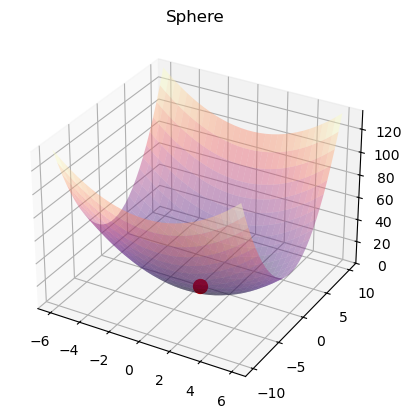

In [35]:
funcs = tf.getAllFunctions()
x = Solution(2,funcs[0][1],funcs[0][0])
func = funcs[0][4]
result = TLBOAlgorithm(x,func)
func = funcs[0]
params = result
plot3DWithAnimation(func[0],func[1],func[2],func[3],func[4],params,'SphereTeacher.gif')

In [36]:
result

[(0.22011215950719176, 1.193957004702611, 1.47398269184135),
 (0.017706640999585892, 0.05979650800543408, 0.0038891475051321582),
 (-0.0015174600137373541, 0.0014189395108952542, 4.3160742288714344e-06),
 (0.0013897479136653198, 0.0008753106933610533, 2.697568073449317e-06),
 (-9.450074453333728e-06, 1.6370565136246872e-05, 3.572993100536523e-10),
 (1.0224855058139506e-06, 9.320206682523302e-06, 8.79117292145516e-11),
 (-2.7437546651422982e-06, -1.5884353107040941e-06, 1.0051316398781738e-11),
 (7.370000818496101e-08, 8.633345103941937e-09, 5.5062258541470776e-15)]

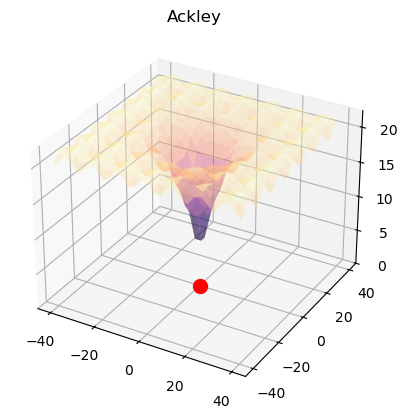

In [37]:
funcs = tf.getAllFunctions()
x = Solution(2,funcs[1][1],funcs[1][0]) # 30 dimensions 
func = funcs[1][4]
result = TLBOAlgorithm(x,func)
func = funcs[1]
params = result
plot3DWithAnimation(func[0],func[1],func[2],func[3],func[4],params,'TeacherAckley.gif')

In [ ]:
def pickBestSolution(progressTracker):
    if len(progressTracker) == 0: # If algorithm didnt pick best solution before hiting evaluation count limit
        return -1
    lastSol = progressTracker[-1]
    # progressTracker records are in form -> (x, y, result), x & y is redundant for us as experiments are going to have much more dimensions, but result is going to be correct for no matter the dimension size
    return lastSol[-1] # result is last one

# Experiment part, saves every experiment data into dictionary and then converts it into pandas df
def experiment(solution, func):
    results = {
        "Experiment N.": [],
        "Differential": [],
        "Swarm": [],
        "SOMA": [],
        "Fireflies": [],
        "Teacher-Student": []
    }
    for i in range(0,30):
        results["Experiment N."].append(i)

        diffResult = diff.DifferentialEvolution(solution, func)
        results["Differential"].append(pickBestSolution(diffResult))

        swarmResult = swarm.ParticleSwarm(solution, func)
        results["Swarm"].append(pickBestSolution(swarmResult))

        somaResult = soma.SOMA(solution, func)
        results["SOMA"].append(pickBestSolution(somaResult))

        fireResult = fire.Fireflies(solution, func)
        results["Fireflies"].append(pickBestSolution(fireResult))

        teacherResult = TLBOAlgorithm(solution, func)
        results["Teacher-Student"].append(pickBestSolution(teacherResult))
    return pd.DataFrame(results)


In [24]:
# Ackley
funcs = tf.getAllFunctions()
x = Solution(30,funcs[1][1],funcs[1][0])
func = funcs[1][4]
result = experiment(x,func)
result.to_csv("csv/AckleyResults.csv")
result.to_excel("tables/AckleyResults.xlsx")

In [ ]:
# Do experiment for every function, save results both as excel table and csv file
funcs = tf.getAllFunctions() # Func format is (minX, maxX, minY, maxY, func)
funcNames = ["Sphere", "Ackley", "Rastrigin", "Rosenbrock", "Griewank", "Schwefel", "Levy", "Michalewicz", "Zakharov"]
funcNameIndex = 0
for item in funcs:
    x = Solution(30,item[1],item[0])
    func = item[4]
    result = experiment(x,func)
    result.to_csv(f"csv/{funcNames[funcNameIndex]}Results.csv")
    result.to_excel(f"tables/{funcNames[funcNameIndex]}Results.xlsx")
    funcNameIndex += 1